# COMPARISON LIRPA VS DECOMON: FULLY CONNECTED MNIST

In [1]:
# PART A: TENSORFLOW

In [2]:
import sys

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential

sys.path.append("..")

from numpy.testing import assert_almost_equal

In [3]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras

%matplotlib inline
import numpy as np
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential

print("Notebook run using keras:", keras.__version__)
import sys

sys.path.append("../..")
from decomon import get_range_box, get_range_noise
from decomon.models.convert import clone as convert

Notebook run using keras: 2.8.0


In [4]:
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

### Build and Train a Neural Network on a sinusoide

The sinusoide funtion is defined on a $[-1 ; 1 ]$ interval. We put a factor in the sinusoide to have several periods of oscillations. 


In [5]:
x = np.linspace(-1, 1, 1000)
y = np.sin(10 * x)

We approximate this function by a fully connected network composed of 4 hidden layers of size 100, 100, 20 and 20 respectively. Rectified Linear Units (ReLU) are chosen as activation functions for all the neurons. 

In [6]:
layers = []
layers.append(Dense(100, activation="linear", input_dim=1))  # specify the dimension of the input space
layers.append(Activation("relu"))
layers.append(Dense(100, activation="linear"))
layers.append(Activation("relu"))
layers.append(Dense(20, activation="linear"))
layers.append(Activation("relu"))
layers.append(Dense(20, activation="linear"))
layers.append(Activation("relu"))
layers.append(Dense(1, activation="linear"))
model = Sequential(layers)

2022-09-22 11:13:43.062256: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


we specify the optimization method and the metric, in this case a classical Means Square Error. 

In [8]:
model.compile("adam", "mse")

we train the neural network

In [10]:
model.fit(x, y, batch_size=32, shuffle=True, epochs=100, verbose=0)
# verbose=0 removes the printing along the training

In [11]:
import torch
import torch.nn.functional as F
from torch import nn


class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden_0 = nn.Linear(1, 100)  # input_dim = 1; output_dim = 100
        self.hidden_1 = nn.Linear(100, 100)
        self.hidden_2 = nn.Linear(100, 20)
        self.hidden_3 = nn.Linear(20, 20)
        self.hidden_4 = nn.Linear(1, 20)

        self.layers = [self.hidden_0, self.hidden_1, self.hidden_2, self.hidden_3, self.hidden_4]

    def forward(self, x):
        x = self.hidden_0(x)
        x = F.relu(x)
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        x = self.hidden_4(x)
        return x
        # x = x.view(-1, 128)
        # return x

    def reset_weights(self, model):

        layers = model.layers
        index = 0
        for layer_keras in layers:
            if len(layer_keras.get_weights()):
                print(layer_keras.name)
                layer_torch = self.layers[index]
                weights = layer_keras.get_weights()
                layer_torch.weight.data = torch.from_numpy(np.transpose(weights[0]))
                layer_torch.bias.data = torch.from_numpy(np.transpose(weights[1]))
                index += 1

In [12]:
model_torch = NeuralNet()
model_torch.reset_weights(model)

dense
dense_1
dense_2
dense_3
dense_4


In [13]:
model_torch.reset_weights(model)

dense
dense_1
dense_2
dense_3
dense_4


In [14]:
### check the predictions

In [15]:
x_train_tensor = torch.from_numpy(x[:, None]).float().to("cpu")
y_pred_torch = model_torch(x_train_tensor).cpu().detach().numpy()

In [16]:
y_pred_torch = model_torch(x_train_tensor).cpu().detach().numpy()
y_pred_keras = model.predict(x)

In [17]:
assert_almost_equal(y_pred_keras, y_pred_torch, decimal=6)

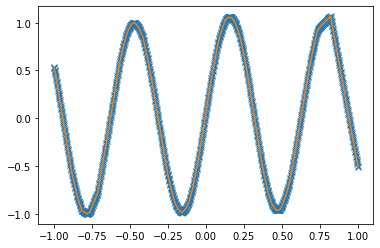

In [18]:
plt.plot(x, y_pred_torch, "x")
plt.plot(x, y_pred_keras)

# DECOMON

In [20]:
import sys

sys.path.append("../..")
from decomon import get_range_noise
from decomon.models.convert import clone as convert

In [21]:
convex_domain = {"name": "ball", "p": 2, "eps": max(0, 0.01)}

In [28]:
# convert our model into a decomon model:
decomon_model_0 = convert(model, method="hybrid", convex_domain=convex_domain, ibp=True, forward=False)

In [23]:
decomon_model_1 = convert(model, method="crown", convex_domain=convex_domain)

> /Users/ducoffe/Documents/Code/open_sourcing/Airbus/decomon/decomon/models/backward_cloning.py(435)crown_()
    433         except ValueError:
    434             import pdb; pdb.set_trace()
--> 435     if not isinstance(backward_bounds_, list):
    436         backward_bounds=[e for e in backward_bounds_]
    437     else:

ipdb> q


BdbQuit: 

# AUTO LIRPA

In [24]:
def get_range_noise_comparison(x, method, model_decomon_1, model_torch, eps):

    X_lirpa = torch.from_numpy(x).float().to("cpu")
    model_lirpa = BoundedModule(model_torch, torch.empty_like(X_lirpa))
    ptb = PerturbationLpNorm(norm=2, eps=eps)
    input_lirpa = BoundedTensor(X_lirpa, ptb)

    if method == "crown":
        lb, ub = model_lirpa.compute_bounds(x=(input_lirpa,), IBP=False, method="backward")
    else:
        lb, ub = model_lirpa.compute_bounds(x=(input_lirpa,), method="IBP+backward")

    lb_p = lb.cpu().detach().numpy()
    ub_p = ub.cpu().detach().numpy()

    ub_t, lb_t = get_range_noise(model_decomon_1, x, eps=eps, p=2, batch_size=-1)
    return lb_p, ub_p, lb_t, ub_t

    return lb_, ub_

In [30]:
lb_p_0, ub_p_0, lb_t_0, ub_t_0 = get_range_noise_comparison(x, "IBP", decomon_model_0, model_torch, 0.01)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1000 and 1x100)

In [41]:
lb_p_1, ub_p_1, lb_t_1, ub_t_1 = get_range_noise_comparison(x, "crown", decomon_model_1, model_torch, 0.01)

In [21]:
y_pred_keras[:4, :4]

array([[-0.20989276,  0.07228097, -0.14889354,  0.07270493],
       [-0.01263764,  0.00435204, -0.00896488,  0.00437756],
       [-0.0136787 ,  0.00471054, -0.00970338,  0.00473818],
       [-0.16452368,  0.05665716, -0.11670962,  0.05698949]],
      dtype=float32)

In [39]:
lb_t_0[:4, :4] - lb_p_0[:4, :4]

array([[ 3.43399481e-08,  7.45058060e-09,  5.24505976e-08,
        -2.98023224e-08],
       [ 4.65661287e-09, -3.56153725e-10,  1.49608603e-10,
        -2.73407169e-09],
       [ 3.98737717e-09, -6.96312329e-10,  4.65661287e-09,
        -3.72529030e-09],
       [ 3.77032204e-08,  0.00000000e+00,  2.44693822e-08,
        -3.22045447e-08]])

In [43]:
lb_t_1[:4, :4] - lb_p_1[:4, :4]

array([[ 1.04066546e-08,  0.00000000e+00,  4.90481864e-08,
        -1.81980561e-08],
       [ 2.79396772e-09,  6.68141608e-10,  1.87466037e-09,
        -2.73407169e-09],
       [ 2.32991322e-09, -7.90536183e-10,  3.72529030e-09,
        -3.72529030e-09],
       [ 1.89180373e-08, -7.45058060e-09,  2.18024154e-08,
        -2.15366774e-08]])

In [27]:
lb_p_1[:4, :4]

array([[-0.21146044,  0.07075053, -0.15099666,  0.07058021],
       [-0.01479847,  0.00227967, -0.01153217,  0.00180498],
       [-0.01580424,  0.00266596, -0.0122427 ,  0.00219666],
       [-0.16609131,  0.05512673, -0.11881272,  0.05486476]],
      dtype=float32)

In [79]:
lb_t_0[:4]

array([[-9.747616],
       [-9.606062],
       [-9.860919],
       [-9.508846]], dtype=float32)

In [45]:
ub_p_0[:4] - ub_t_0[:4]

array([[-0.29362977],
       [-0.2996661 ],
       [-0.30433547],
       [-0.29977193]], dtype=float32)

In [83]:
lb_p_1[:4]

array([[0.12279916],
       [0.2643544 ],
       [0.00950484],
       [0.3615697 ]], dtype=float32)

In [46]:
ub_p_1[:4] - ub_t_1[:4]

array([[-0.00122985],
       [-0.00121457],
       [-0.0011619 ],
       [-0.0012141 ]], dtype=float32)

array([[0.01428786],
       [0.02118983],
       [0.03009777],
       [0.02139367]], dtype=float32)

In [22]:
assert_almost_equal(lb_p_0, lb_t_0, decimal=5)

AssertionError: 
Arrays are not almost equal to 5 decimals

Mismatched elements: 100 / 100 (100%)
Max absolute difference: 0.17100443
Max relative difference: 1.1917577
 x: array([[-0.01807],
       [-0.19317],
       [-0.15251],...
 y: array([[-0.15077],
       [-0.36417],
       [-0.29331],...

In [29]:
assert_almost_equal(ub_p_0, ub_t_0, decimal=5)

AssertionError: 
Arrays are not almost equal to 5 decimals

Mismatched elements: 100 / 100 (100%)
Max absolute difference: 0.80073017
Max relative difference: 1.2678194
 x: array([[-0.1643 ],
       [-0.01927],
       [ 0.06649],...
 y: array([[0.63449],
       [0.68148],
       [0.69781],...

In [26]:
# define the intervals


def get_range_box_comparison(method, model_decomon_1, model_torch, x_min=x.min(), x_max=x.max(), n_split=10):

    alpha = np.linspace(0, 1, n_split + 1)
    x_samples = (1 - alpha) * x_min + alpha * x_max
    X_min = x_samples[:-1][:, None]
    X_max = x_samples[1:][:, None]
    X_lirpa_ = (X_min + X_max) / 2.0
    eps = 0.5 * (x_max - x_min) / n_split

    # convert X_lirpa into a pytorch tensor
    X_lirpa = torch.from_numpy(X_lirpa_).float().to("cpu")

    model_lirpa = BoundedModule(model_torch, X_lirpa)
    ptb = PerturbationLpNorm(norm=np.inf, eps=eps)
    input_lirpa = BoundedTensor(X_lirpa, ptb)

    if method == "crown":
        IBP = False
    else:
        IBP = True

    lb, ub = model_lirpa.compute_bounds(x=(input_lirpa,), IBP=IBP, method=method)

    lb_ = lb.cpu().detach().numpy()
    ub_ = ub.cpu().detach().numpy()

    # upper_0, lower_0 = get_range_noise(model_decomon_0, X_lirpa_, eps, p=np.inf)
    upper_, lower_ = get_range_box(model_decomon_1, X_min, X_max, fast=True)
    # upper_ = np.minimum(upper_0, upper_0)
    # lower_ = np.maximum(lower_1, lower_1)

    return X_lirpa_, model.predict(X_lirpa_), lb_, ub_, lower_, upper_

In [27]:
x_samples, y_samples, lb_p_0, ub_p_0, lb_t_0, ub_t_0 = get_range_box_comparison(
    "crown-ibp", decomon_model_0, model_torch, n_split=10
)

In [28]:
x_samples, y_samples, lb_p_1, ub_p_1, lb_t_1, ub_t_1 = get_range_box_comparison(
    "crown", decomon_model_1, model_torch, n_split=10
)

In [29]:
ub_p_0 - ub_t_0

array([[ 9.5367432e-07],
       [ 1.3113022e-06],
       [ 7.1525574e-07],
       [-4.7683716e-07],
       [ 0.0000000e+00],
       [ 4.7683716e-07],
       [-1.9073486e-06],
       [ 2.3841858e-07],
       [ 1.4305115e-06],
       [ 9.5367432e-07]], dtype=float32)

In [30]:
assert_almost_equal(ub_p_0, ub_t_0, decimal=5)

In [31]:
assert_almost_equal(lb_p_0, lb_t_0, decimal=5)

In [33]:
assert_almost_equal(lb_p_1, lb_t_1, decimal=5)

In [34]:
assert_almost_equal(ub_p_1, ub_t_1, decimal=5)